МОДЕЛИРОВАНИЕ ЦЕПНОЙ ЯДЕРНОЙ РЕАКЦИИ

In [ ]:
import random
import math
import matplotlib.pyplot as plt

**Параметры модели**

Цепная ядерная реакция — это последовательность единичных ядерных реакций, каждая из которых вызывается частицей, появившейся как продукт реакции на предыдущем шаге последовательности. Примером цепной ядерной реакции является реакция деления ядер тяжёлых элементов, при которой основное число актов деления инициируется нейтронами, полученными при делении ядер в предыдущем поколении.

Развитие цепной реакции в некотором объёме, заполненном расщепляющимся веществом можно описать следующим образом:

- частица характеризуется своим положением в пространстве r = (x,y,z) и скоростью V = (u, v, w);
- концентрация частиц в объёме мала, так что можно пренебречь их взаимодействием друг с другом;
- частицы взаимодействуют с веществом таким образом, что вероятности различных видов взаимодействия не зависит от предыстории частицы;
- вещество находится в стационарном состоянии, т.е. плотность вещества и его состав не меняется в зависимости от времени.


При сформулированных предположениях процесс слагается из независимых «историй» частиц. История частицы начинается с её рождения. Рождение происходит в определённый момент в определённой точке пространства и при этом частица приобретает случайную скорость в соответствии с заданной функцией распределения. Далее частица движется прямолинейно и равномерно до столкновения с атомом вещества или вылетает в окружающее пространство. Вероятность столкновения на малом пути dl равна λdl. Величина  λ определяется экспериментально или с помощью теоретического расчёта для данного вещества и данного типа частиц. Таким образом, длина свободного пробега частицы l распределена по показательному закону с параметром λ.

> H(l)=1- e^(-λl)

Типы взаимодействия в простейших случаях разделяются на три группы – рассеяние, поглощение и деление. При рассеянии изменяется скорость частицы. При поглощении частица поглощается веществом и её история прекращается. При делении возникает несколько новых частиц, т.е. возникает новый (вторичный) источник. Какое взаимодействие произойдёт в каждом конкретном случае, определяется в соответствии с экспериментально найденным распределением вероятностей


In [ ]:
lambda_param = 1.2  # Предполагаемая константа распада для данного материала
num_particles = 150  # Начальное количество частиц
max_interactions = 10000  # Ограничение на максимальное количество взаимодействий
absorption_probability = 0.15  # Вероятность поглощения частицы
scattering_probability = 0.75  # Вероятность рассеяния частицы
fission_probability = 1 - (absorption_probability + scattering_probability)  # Вероятность деления
fission_particles = 3  # Количество новых частиц, образующихся при делении
max_particle_count = 800  # Параметр максимального количества частиц, после которого симуляция будет остановлена

Функция для подсчета длины свободного пробега

Случайную величину l, распределённую по показательному закону с параметром λ можно разыграть по формуле


> l = -1/λ ln(1-R)

, где R – стандартная случайная величина, равномерно распределённая на отрезке [0,1], а поскольку (1 – R) и R распределены одинаково, можно немного упростить вычисление:


> l = -(ln(R))/λ

Математическое ожидание длины свободного пробега равно 1/λ.


In [ ]:
def free_path_length():
    R = random.uniform(0, 1)
    return -(math.log(R) / lambda_param) # l = - ln(R)/lambda

Функция для определения типа взаимодействия

In [ ]:
def interaction():
    R = random.uniform(0, 1)
    if R < absorption_probability:
        return 'absorption' #поглощение
    elif R < absorption_probability + scattering_probability:
        return 'scattering' #рассеяние
    else:
        return 'fission'  #деление

Рассчитываем новую позицию частицы после движения

In [ ]:
def move_particle(position, distance):
    angle_theta = random.uniform(0, 2 * math.pi) #угол в плоскости XY, определяющий направление движения частицы в горизонтальной плоскости
    angle_phi = random.uniform(0, math.pi) #угол относительно вертикальной оси, определяющий наклон частицы в пространстве
    new_x = position[0] + distance * math.sin(angle_phi) * math.cos(angle_theta)
    new_y = position[1] + distance * math.sin(angle_phi) * math.sin(angle_theta) #новые координаты определяются как смещение относительно предыдущего положения
    new_z = position[2] + distance * math.cos(angle_phi)
    return new_x, new_y, new_z

Функция симуляции

In [ ]:
def simulate_particles_in_sphere(radius):
    particles = [{'position': (0, 0, 0), 'alive': True} for _ in range(num_particles)]
    interactions = 0
    particles_inside_history = [num_particles]

    while len(particles) > 0 and interactions < max_interactions and len(particles) < max_particle_count:
        interactions += 1
        newly_created_particles = []  # Хранение новых частиц от деления

        for particle in particles:
            if particle['alive']:
                distance = free_path_length()
                new_position = move_particle(particle['position'], distance)

                if math.sqrt(new_position[0] ** 2 + new_position[1] ** 2 + new_position[2] ** 2) > radius:
                    particle['alive'] = False
                    continue

                interaction_type = interaction()

                if interaction_type == 'absorption':
                    particle['alive'] = False
                elif interaction_type == 'fission':
                    particle['alive'] = False
                    for _ in range(fission_particles):
                        if len(newly_created_particles) < max_particle_count:
                            newly_created_particles.append({'position': new_position, 'alive': True})
                        else:
                            break
                # Если произошло рассеяние, частица продолжает участвовать в реакции, и позиция не меняется

        # Добавляем новые частицы из деления
        particles.extend(newly_created_particles)
        # Удаляем поглощенные частицы
        particles = [p for p in particles if p['alive']]
        if len(particles) > max_particle_count:
            print(
                f"Моделирование остановлено: число частиц превысило {max_particle_count} после {interactions} взаимодействий.")
            break
        particles_inside_history.append(len(particles))

    return len(particles), interactions, particles_inside_history  # Возвращаем количество частиц и взаимодействий

In [ ]:
def simulate_particles_in_sphere_with_visualization(radius):
    final_count, interactions, particles_inside_history = simulate_particles_in_sphere(radius)

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.plot(particles_inside_history, marker='o')
    plt.xlabel('Количество взаимодействий')
    plt.ylabel('Число частиц внутри шара')
    plt.title(f'Имитационная модель прохождения частиц в шаре радиусом {radius}')
    plt.grid(True)
    plt.show()

    print(f"Оставшиеся частицы после {interactions} взаимодействий: {final_count}")
    return final_count, interactions

Расчет взаимодействия частиц для разных радиусов шара

In [ ]:
def explore_volume_effect():
    radiuses = [2, 4, 5, 10, 1000]  #различные радиусы шара
    for radius in radiuses:
        final_count, interactions = simulate_particles_in_sphere_with_visualization(radius)


        if final_count < num_particles:
            print("Реакция затухает.")
        elif final_count == num_particles:
            print("Реакция стабилизируется.")
        else:
            print("Реакция лавинообразно возрастает.")
        print(f"Радиус шара: {radius}, окончательное количество частиц: {final_count}, взаимодействий: {interactions}")
        print("-------------------------------------------------------------------------------------")

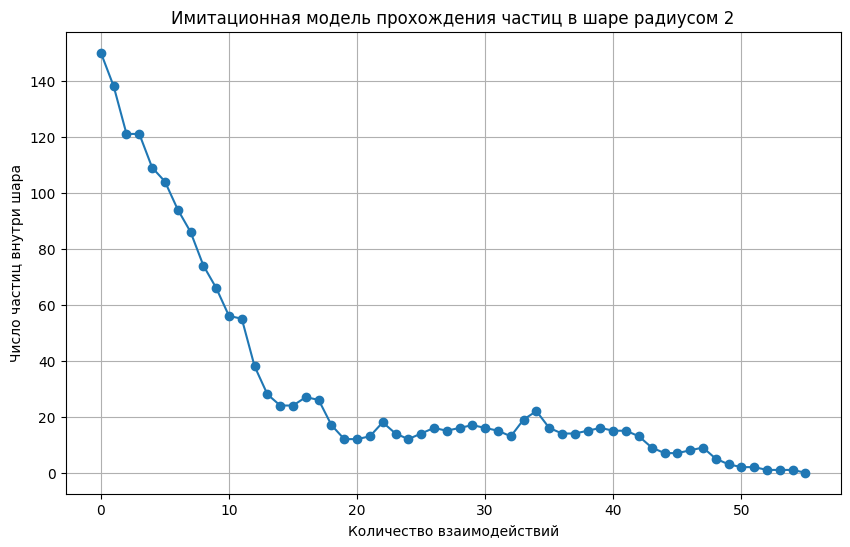

Оставшиеся частицы после 55 взаимодействий: 0
Реакция затухает.
Радиус шара: 2, окончательное количество частиц: 0, взаимодействий: 55
-------------------------------------------------------------------------------------


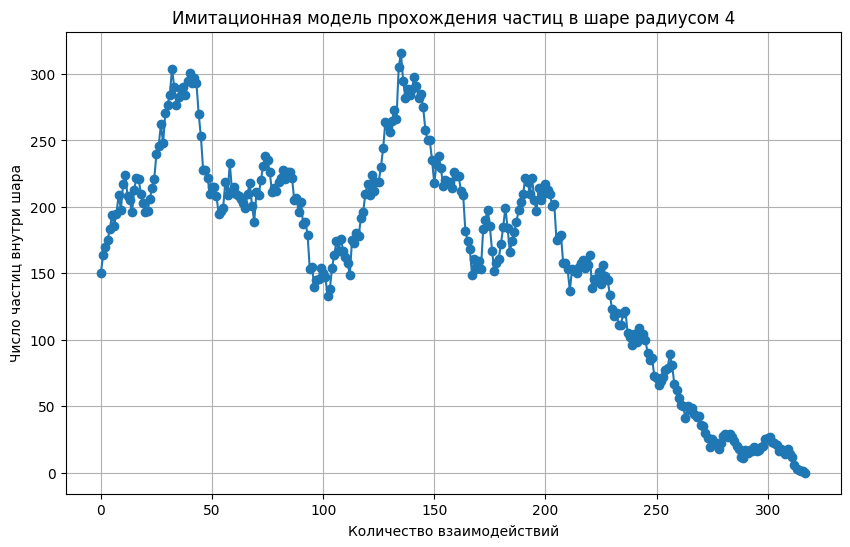

Оставшиеся частицы после 317 взаимодействий: 0
Реакция затухает.
Радиус шара: 4, окончательное количество частиц: 0, взаимодействий: 317
-------------------------------------------------------------------------------------
Моделирование остановлено: число частиц превысило 800 после 85 взаимодействий.


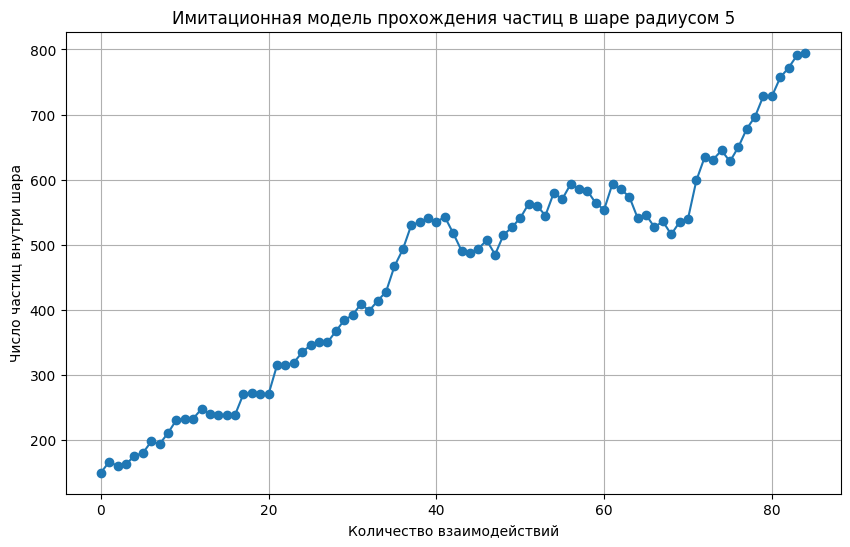

Оставшиеся частицы после 85 взаимодействий: 832
Реакция лавинообразно возрастает.
Радиус шара: 5, окончательное количество частиц: 832, взаимодействий: 85
-------------------------------------------------------------------------------------
Моделирование остановлено: число частиц превысило 800 после 37 взаимодействий.


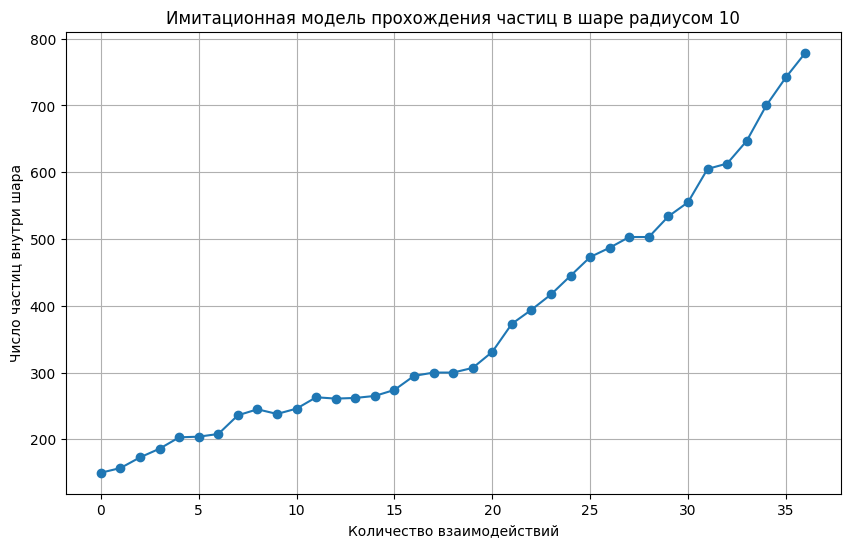

Оставшиеся частицы после 37 взаимодействий: 801
Реакция лавинообразно возрастает.
Радиус шара: 10, окончательное количество частиц: 801, взаимодействий: 37
-------------------------------------------------------------------------------------
Моделирование остановлено: число частиц превысило 800 после 29 взаимодействий.


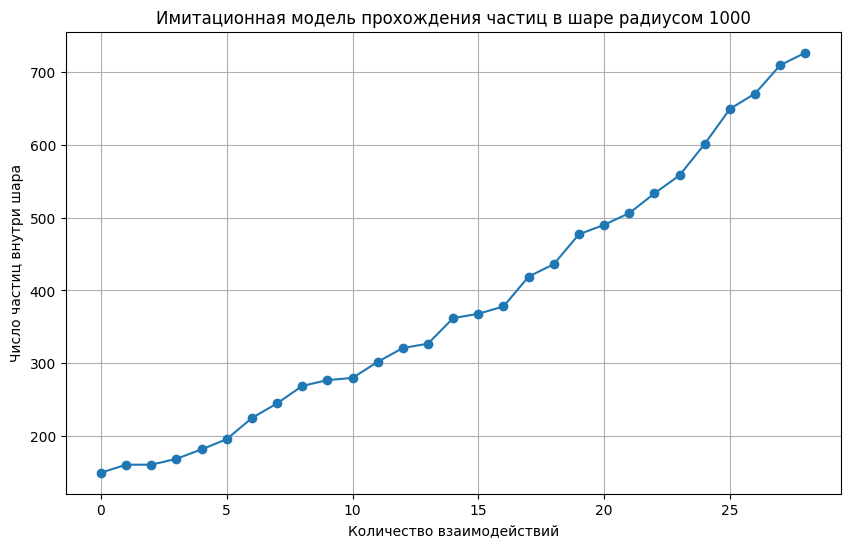

Оставшиеся частицы после 29 взаимодействий: 801
Реакция лавинообразно возрастает.
Радиус шара: 1000, окончательное количество частиц: 801, взаимодействий: 29
-------------------------------------------------------------------------------------


In [ ]:
explore_volume_effect()

# Вывод

При малых радиусах (r = 2, 4) существует высокая вероятность того, что частица выйдет за пределы сферы после рассеяния или деления. После некоторого числа взаимодействий все частицы либо покидают эту область, либо поглощаются.

При увеличении радиуса сферы (r = 5, 10, 1000) существует больше места для рассеяния и деления частиц внутри сферы. Это увеличивает вероятность того, что частицы останутся внутри сферы после каждого взаимодействия, что приводит к увеличению числа частиц в системе со временем.

Для того чтобы реакция была в равновесии, необходимо тонко настроить параметры модели (вероятности рассеяния, поглощения и деления), чтобы количество создаваемых частиц при делении их было равным количеству поглощаемых и рассеиваемых частиц.